# Implementation 1

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from keras_preprocessing.image import ImageDataGenerator
import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy import ndimage, misc
from scipy.ndimage.interpolation import zoom

import os
import glob
import cv2
from bs4 import BeautifulSoup
import statistics
import pandas as pd

In [2]:
curr_directory = os.getcwd()
train_img_path = curr_directory + "\\train\\"
test_img_path = curr_directory + "\\test\\"
files_train = [f for f in glob.glob(train_img_path + "*.jpg", recursive = True)]
files_test = [f for f in glob.glob(test_img_path + "*.jpg", recursive = True)]
files_train_xml = [f for f in glob.glob(train_img_path + "*.xml", recursive = True)]
files_test_xml = [f for f in glob.glob(test_img_path + "*.xml", recursive = True)]


- PrePocess_CV2 method uses opencv cv2 library to resize the image
- Using this method, we cut off one particular channel from the image and so we lose the original image properties

In [3]:
tiny_image_size_x = 64
tiny_image_size_y = 64
number_of_labels = 4

def PreProcess_CV2(files):
    x_res = None
    y_res = []
    for i in range(0, len(files)):
        img_array = cv2.imread(files[i])
        img_tiny = cv2.resize(img_array, (tiny_image_size_x,tiny_image_size_y))

        if x_res is None:
            x_res = img_tiny
        else:
            x_res = np.concatenate((x_res, img_tiny))
        y_res.append(os.path.basename(files[i]).split('_')[0])

    x_res = x_res.reshape(-1, tiny_image_size_x, tiny_image_size_y, 3)
    le = LabelEncoder()
    le.fit(y_res)
    y_res = le.transform(y_res)
    y_res = tf.keras.utils.to_categorical(y_res, number_of_labels)
    return x_res , y_res

x_train,y_train = PreProcess_CV2(files_train)
x_test,y_test = PreProcess_CV2(files_test)

- Below is a blue apple image which is generated using the preprocess_cv2 method above
- The apple loses its orginal color since we resized it using cv2

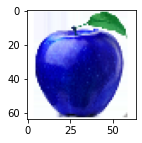

In [4]:
img2 = Image.fromarray(x_train[0])

plt.subplots(figsize=(2,2))
plt.imshow(img2)

In [5]:
keras.backend.clear_session()
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32,
    kernel_size=(3, 3),
    activation='relu',
    input_shape=(tiny_image_size_x, tiny_image_size_y, 3)))
model.add(tf.keras.layers.Conv2D(filters=32,
    kernel_size=(5, 5),
    activation='relu',
    input_shape=(tiny_image_size_x, tiny_image_size_y, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(rate=0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=number_of_labels, activation='softmax'))

In [6]:
model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [7]:
hist = model.fit(x=x_train/255, y=y_train, epochs=10)

Epoch 1/10
8/8 [==============================] - 1s 135ms/step - loss: 2.3352 - accuracy: 0.3292
Epoch 2/10
8/8 [==============================] - 1s 135ms/step - loss: 1.1311 - accuracy: 0.3667
Epoch 3/10
8/8 [==============================] - 1s 141ms/step - loss: 0.8479 - accuracy: 0.7125
Epoch 4/10
8/8 [==============================] - 1s 146ms/step - loss: 0.5197 - accuracy: 0.8083
Epoch 5/10
8/8 [==============================] - 1s 142ms/step - loss: 0.5202 - accuracy: 0.7917
Epoch 6/10
8/8 [==============================] - 1s 137ms/step - loss: 0.3986 - accuracy: 0.8583
Epoch 7/10
8/8 [==============================] - 1s 134ms/step - loss: 0.3238 - accuracy: 0.8875
Epoch 8/10
8/8 [==============================] - 1s 133ms/step - loss: 0.2969 - accuracy: 0.8875
Epoch 9/10
8/8 [==============================] - 1s 126ms/step - loss: 0.1934 - accuracy: 0.9500
Epoch 10/10
8/8 [==============================] - 1s 127ms/step - loss: 0.1574 - accuracy: 0.9458


In [8]:
loss, accuracy = model.evaluate(x=x_test, y=y_test)

print('loss =', loss)
print('accuracy =', accuracy)

2/2 [==============================] - 0s 10ms/step - loss: 75.0880 - accuracy: 0.8833
loss = 75.08802795410156
accuracy = 0.8833333253860474


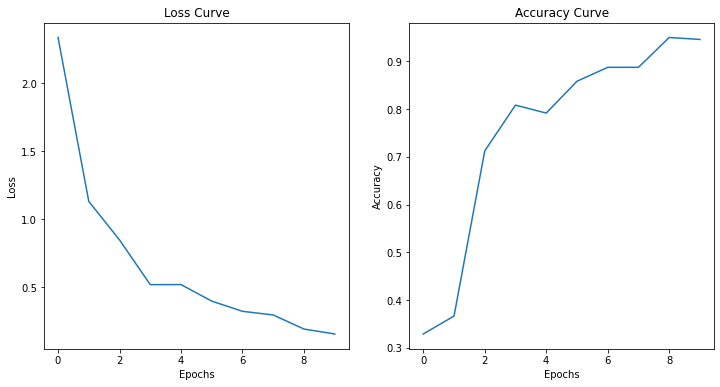

In [9]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax[0].plot(hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curve')

ax[1].plot(hist.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Curve')

plt.show()

# Implementation 2
- Here we use PreProcess_Pillow method to resize the image using Pillow library
- Doing this we retain the original properties of the image

In [10]:
def PreProcess_Pillow(files,isOneHot):
    x_res = None
    y_res = []

    for i in range(0, len(files)):
        img_raw = Image.open(files[i])
        img_tiny = img_raw.resize((tiny_image_size_x,tiny_image_size_y))
        if img_tiny.mode == 'RGBA' or img_tiny.mode == 'P':
            img_tiny = img_tiny.convert('RGB')
        if x_res is None:
            x_res = img_tiny
        else:
            x_res = np.concatenate((x_res, img_tiny))
        y_res.append(os.path.basename(files[i]).split('_')[0])

    x_res = x_res.reshape(-1, tiny_image_size_x, tiny_image_size_y, 3)
    le = LabelEncoder()
    y_res = le.fit_transform(y_res)
    if isOneHot:
        y_res = tf.keras.utils.to_categorical(y_res, number_of_labels)
    return x_res , y_res

x_train,y_train = PreProcess_Pillow(files_train,True)
x_test,y_test = PreProcess_Pillow(files_test,True)

C:\Users\manas\anaconda3\envs\pythonProject\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


- Below is a red apple image which is generated using the preprocess_cv2 method above
- The apple loses its orginal color since we resized it using cv2

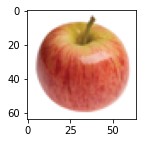

In [11]:
img2 = Image.fromarray(x_train[1])

plt.subplots(figsize=(2,2))
plt.imshow(img2)

In [12]:
keras.backend.clear_session()
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32,
    kernel_size=(3, 3),
    activation='relu',
    input_shape=(tiny_image_size_x, tiny_image_size_y, 3)))
model.add(tf.keras.layers.Conv2D(filters=32,
    kernel_size=(5, 5),
    activation='relu',
    input_shape=(tiny_image_size_x, tiny_image_size_y, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(rate=0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=number_of_labels, activation='softmax'))

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
hist = model.fit(x=x_train/255, y=y_train, epochs=10)

Epoch 1/10
8/8 [==============================] - 1s 136ms/step - loss: 1.8909 - accuracy: 0.3500
Epoch 2/10
8/8 [==============================] - 1s 127ms/step - loss: 1.2004 - accuracy: 0.4667
Epoch 3/10
8/8 [==============================] - 1s 128ms/step - loss: 1.0812 - accuracy: 0.5500
Epoch 4/10
8/8 [==============================] - 1s 129ms/step - loss: 0.8029 - accuracy: 0.7375
Epoch 5/10
8/8 [==============================] - 1s 129ms/step - loss: 0.5665 - accuracy: 0.8083
Epoch 6/10
8/8 [==============================] - 1s 128ms/step - loss: 0.4735 - accuracy: 0.8125
Epoch 7/10
8/8 [==============================] - 1s 127ms/step - loss: 0.3262 - accuracy: 0.9042
Epoch 8/10
8/8 [==============================] - 1s 127ms/step - loss: 0.2477 - accuracy: 0.8750
Epoch 9/10
8/8 [==============================] - 1s 128ms/step - loss: 0.2697 - accuracy: 0.9125
Epoch 10/10
8/8 [==============================] - 1s 128ms/step - loss: 0.1717 - accuracy: 0.9458


In [15]:

loss, accuracy = model.evaluate(x=x_test, y=y_test)

print('loss = ', loss)
print('accuracy = ', accuracy)

2/2 [==============================] - 0s 10ms/step - loss: 121.1714 - accuracy: 0.8500
loss =  121.17137145996094
accuracy =  0.8500000238418579


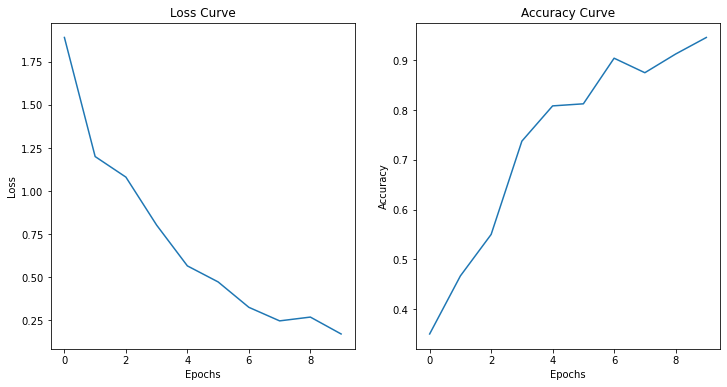

In [16]:

%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax[0].plot(hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curve')

ax[1].plot(hist.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Curve')

plt.show()

# Implementation 3
- Here we are using a Image Data Generator to generate more images to observe the accuracy of our model

In [17]:
x_train,y_train = PreProcess_Pillow(files_train,False)
x_test,y_test = PreProcess_Pillow(files_test,False)

trainGen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

testGen = ImageDataGenerator(rescale = 1./255)

# takes some time to load btw.
train_generator = trainGen.flow(x=x_train, y=y_train, batch_size=25, shuffle=True)
test_generator = testGen.flow(x=x_test, y=y_test, batch_size=25, shuffle=True)

In [18]:
keras.backend.clear_session()
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32,
    kernel_size=(3, 3),
    activation='relu',
    input_shape=(tiny_image_size_x, tiny_image_size_y, 3)))
model.add(tf.keras.layers.Conv2D(filters=32,
    kernel_size=(5, 5),
    activation='relu',
    input_shape=(tiny_image_size_x, tiny_image_size_y, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(rate=0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=number_of_labels, activation='softmax'))

In [19]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
hist = model.fit(train_generator,
                           validation_data=test_generator,
                 steps_per_epoch = 10,
                           epochs=10)

Epoch 1/10
10/10 [==============================] - 1s 137ms/step - loss: 1.3500 - accuracy: 0.3625 - val_loss: 1.2845 - val_accuracy: 0.4167
Epoch 2/10
10/10 [==============================] - 1s 124ms/step - loss: 1.2949 - accuracy: 0.3875 - val_loss: 1.1757 - val_accuracy: 0.6667
Epoch 3/10
10/10 [==============================] - 1s 119ms/step - loss: 1.2095 - accuracy: 0.5708 - val_loss: 1.0979 - val_accuracy: 0.7333
Epoch 4/10
10/10 [==============================] - 1s 123ms/step - loss: 1.1186 - accuracy: 0.6333 - val_loss: 1.1703 - val_accuracy: 0.5500
Epoch 5/10
10/10 [==============================] - 1s 117ms/step - loss: 1.0800 - accuracy: 0.6542 - val_loss: 1.0535 - val_accuracy: 0.6833
Epoch 6/10
10/10 [==============================] - 1s 116ms/step - loss: 1.0116 - accuracy: 0.7333 - val_loss: 0.9690 - val_accuracy: 0.7667
Epoch 7/10
10/10 [==============================] - 1s 117ms/step - loss: 0.9164 - accuracy: 0.8333 - val_loss: 0.9139 - val_accuracy: 0.8333
Epoch 

In [21]:
loss, accuracy = model.evaluate(x_test,y_test)

print(loss)
print(accuracy)

2/2 [==============================] - 0s 10ms/step - loss: 0.9437 - accuracy: 0.8000
0.9436683654785156
0.800000011920929


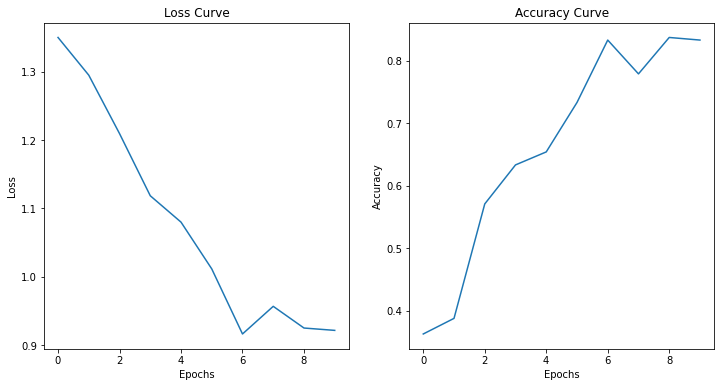

In [22]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax[0].plot(hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curve')

ax[1].plot(hist.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Curve')

plt.show()

# Implementation 4: Building VGG model from scratch

Credits: https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c


In [23]:
model = Sequential()
model.add(Conv2D(input_shape=(tiny_image_size_x, tiny_image_size_y,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=number_of_labels, activation="softmax"))


In [24]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [25]:
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(train_generator,
                           validation_data=test_generator,
                           steps_per_epoch=10,
                           epochs=1,
                           callbacks=[checkpoint,early])

Instructions for updating:
Please use Model.fit, which supports generators.
10/10 [==============================] - ETA: 0s - loss: 1.4676 - accuracy: 0.2625
Epoch 00001: accuracy improved from -inf to 0.26250, saving model to vgg16_1.h5
10/10 [==============================] - 10s 983ms/step - loss: 1.4676 - accuracy: 0.2625 - val_loss: 1.3377 - val_accuracy: 0.3000


In [26]:
loss, accuracy = model.evaluate(x_test,y_test)

print(loss)
print(accuracy)

2/2 [==============================] - 0s 90ms/step - loss: 1.3363 - accuracy: 0.3000
1.3363490104675293
0.30000001192092896


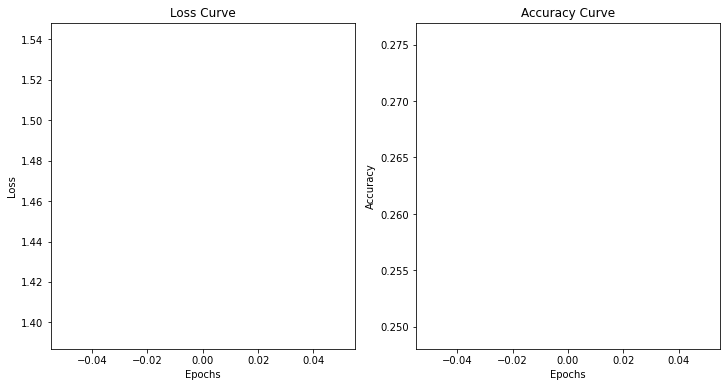

In [27]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax[0].plot(hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curve')

ax[1].plot(hist.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Curve')

plt.show()

# Implementation 5

# How to use XML File to improve accuracy
#### Our strategy:
- The XML File provides the minimum and maximum X and Y values (to reasonable accuracy) of each important fruit object(s) in each image.

- This means that if we can *crop* each image according to these dimensions, we would be able to remove most of the *noise* in each image.

- We have to be careful with images with multiple objects, we have to find the minimum and maximum X and Y values across *all fruit objects* in each image.

In [28]:
#XML Preprocess
def PreProcessXML(files):

    data_crop_xml = []
    for file in files:
        with open(file) as f:
            data = f.read()

        Bs_data = BeautifulSoup(data, "xml")

        x_min = min([int(item.get_text()) for item in Bs_data.find_all('xmin')])
        x_max = max([int(item.get_text()) for item in Bs_data.find_all('xmax')])
        y_min = min([int(item.get_text()) for item in Bs_data.find_all('ymin')])
        y_max = max([int(item.get_text()) for item in Bs_data.find_all('ymax')])

        x_y_data = [x_min,y_max,x_max,y_min]
        data_crop_xml.append(x_y_data)

    return data_crop_xml

data_train_crop_xml = PreProcessXML(files_train_xml)
data_test_crop_xml = PreProcessXML(files_test_xml)

# Finding the Ideal Shape for our data

Our group believes that there are two important criteria for the ideal shape.

The Ideal shape should have:
1. The best possible resolution that our data allows (largest number of pixels)
2. The most commonly used aspect ratio so that the general shape of the fruits in each image do not get overly distorted

## Let's create a histogram to visualize our data using the XML Info

Text(0.5, 1.0, 'Histogram to show distribution of Test Image Aspect Ratios')

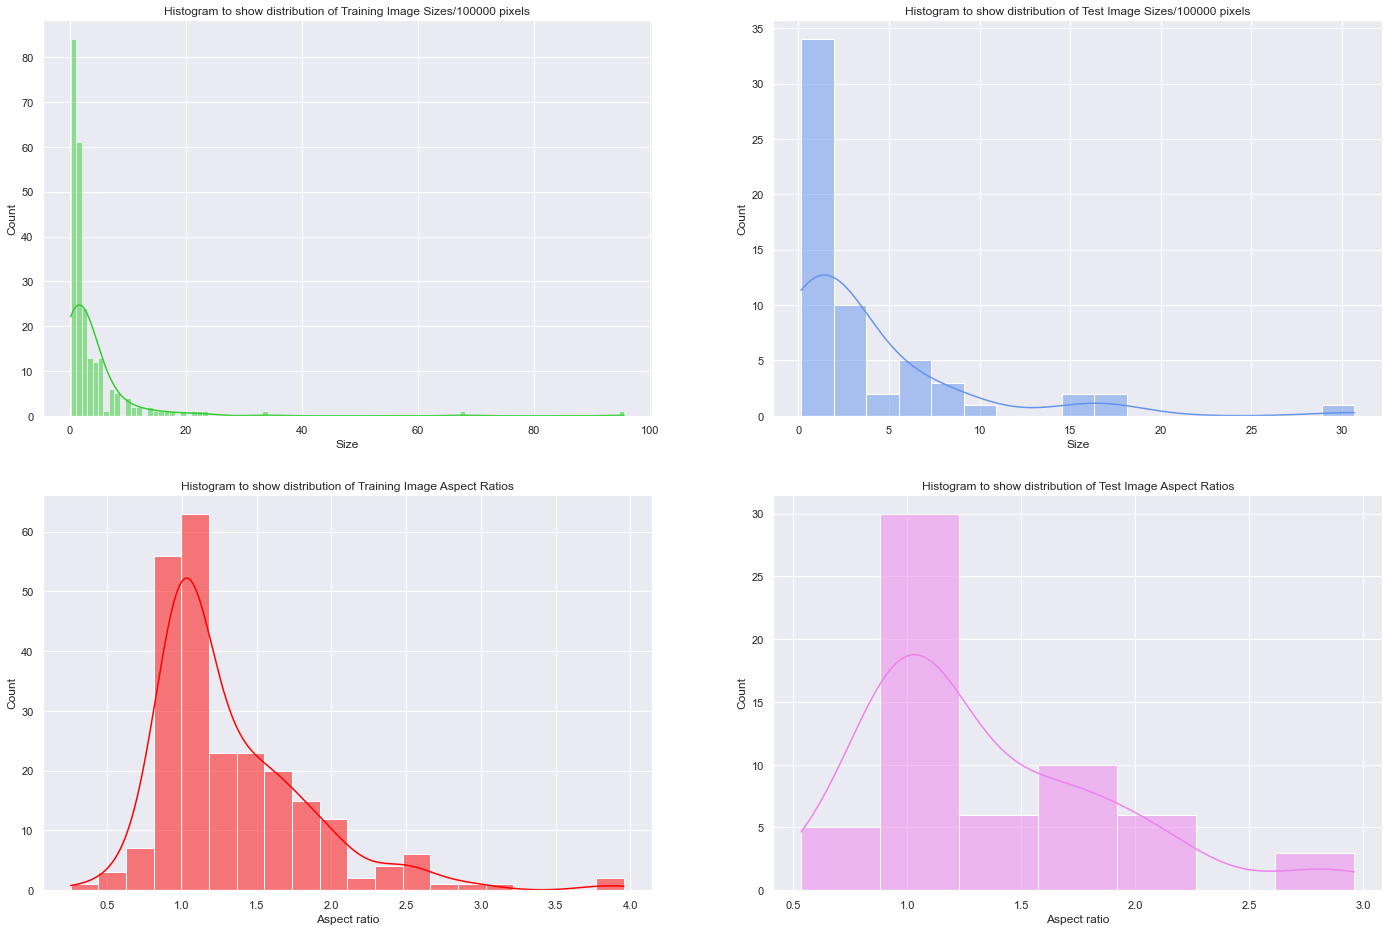

In [29]:

train_img_size_list = []
test_image_size_list = []
def MakeDF(lst,data):
    for i in data:
        width = (i[2] - i[0])
        height = (i[1] - i[3])
        size = width * height
        aspect_ratio = width/height
        new_arr = [size,aspect_ratio]
        lst.append(new_arr)
    return lst


train_img_size_list = MakeDF(train_img_size_list, data_train_crop_xml)
test_image_size_list = MakeDF(test_image_size_list,data_test_crop_xml)
train_size_df = pd.DataFrame(train_img_size_list, columns = ['Size','Aspect ratio'])
test_size_df = pd.DataFrame(test_image_size_list, columns = ['Size','Aspect ratio'])

train_size_df

#plt.hist(train_size_df)
#plt.gca().set(title='Frequency Histogram', ylabel = 'Frequency', xlabel = 'size')
sb.set(style='darkgrid')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24,16))


sb.histplot(data=train_size_df['Size']/100000, color='limegreen', kde=True, ax=ax[0,0]).set_title('Histogram to show distribution of Training Image Sizes/100000 pixels')
sb.histplot(data=test_size_df['Size']/100000, color='cornflowerblue', kde=True, ax=ax[0,1]).set_title('Histogram to show distribution of Test Image Sizes/100000 pixels')
sb.histplot(data=train_size_df['Aspect ratio'], color='red', kde=True, ax=ax[1,0]).set_title('Histogram to show distribution of Training Image Aspect Ratios')
sb.histplot(data=test_size_df['Aspect ratio'], color='violet', kde=True, ax=ax[1,1]).set_title('Histogram to show distribution of Test Image Aspect Ratios')


In [30]:

print("Median number of pixels in each training image is " +str(statistics.median(train_size_df['Size'])))
print("Mean number of pixels in each training image is " +str(statistics.mean(train_size_df['Size'])))
print("Median aspect ratio of each training image is " +str(statistics.median(train_size_df['Aspect ratio'])))
print("Mean aspect ratio of each training image is " + str(statistics.mean(train_size_df['Aspect ratio'])))
print("Mode aspect ratio of each training image is " + str(statistics.mode(train_size_df['Aspect ratio'])))


Median number of pixels in each training image is 150388.0
Mean number of pixels in each training image is 380859.51666666666
Median aspect ratio of each training image is 1.105569605495619
Mean aspect ratio of each training image is 1.3317485017311226
Mode aspect ratio of each training image is 0.9256198347107438


# Observations from data visualization

The distribution on image sizes and aspect ratios in the training data and test data is similar.

Let's see if we can combine all the training data and test data to see its distribution.

Text(0.5, 1.0, 'Histogram to show distribution of all Aspect Ratios')

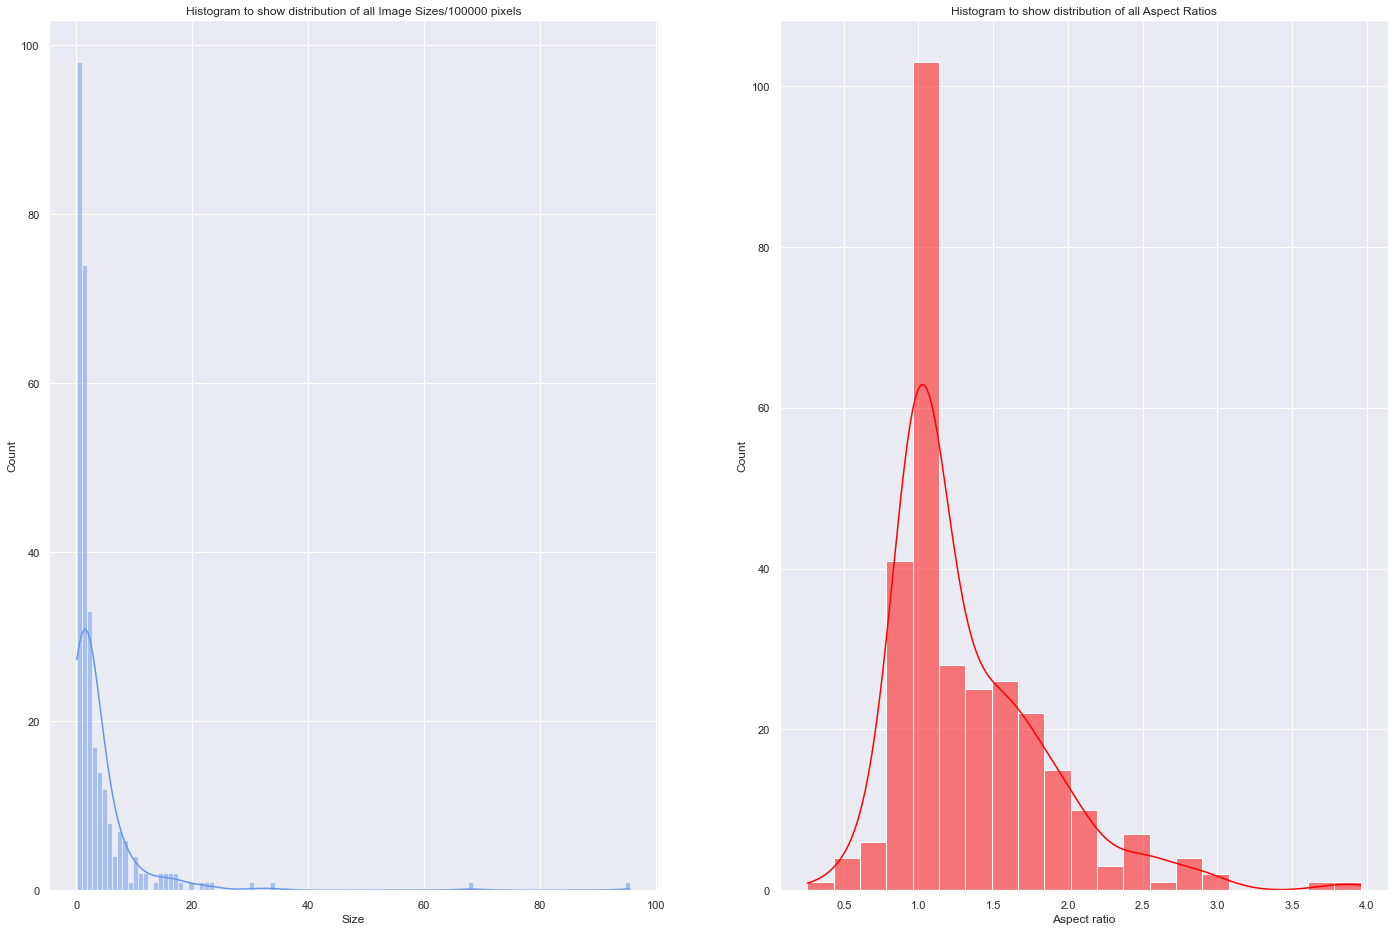

In [31]:
#combining test and train data
combined_df = pd.concat([train_size_df,test_size_df])

sb.set(style='darkgrid')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24,16))
sb.histplot(data=combined_df['Size']/100000, color='cornflowerblue', kde=True, ax=ax[0]).set_title('Histogram to show distribution of all Image Sizes/100000 pixels')
sb.histplot(data=combined_df['Aspect ratio'], color='red', kde=True, ax=ax[1]).set_title('Histogram to show distribution of all Aspect Ratios')

In [32]:
print('Median number of pixels per image is ' + str(statistics.median(combined_df['Size'])))
print('Mean number of pixels per image is ' + str(statistics.mean(combined_df['Size'])))
print('Highest frequency of pixels per image is ' + str(statistics.mode(combined_df['Size'])))
print('Median aspect ratio is ' + str(statistics.median(combined_df['Aspect ratio'])))
print('Mean aspect ratio is ' + str(statistics.mean(combined_df['Aspect ratio'])))
print('Highest frequency aspect ratio is ' + str(statistics.mode(combined_df['Aspect ratio'])))
print('Assuming we use 1:1 aspect ratio, Square root of of mode pixels is '+ str(np.sqrt(statistics.mode(combined_df['Size']))))


Median number of pixels per image is 149293.5
Mean number of pixels per image is 381429.76666666666
Highest frequency of pixels per image is 107882
Median aspect ratio is 1.1142763132427516
Mean aspect ratio is 1.335558452164525
Highest frequency aspect ratio is 1.0638297872340425
Assuming we use 1:1 aspect ratio, Square root of of mode pixels is 328.4539541549165


# Choices for the Ideal Shape

### Aspect Ratio chosen: 1:1 (square)

### Resolution chosen: (330 pixels per side)

In [33]:
label_map = {'apple':0,'orange':1,'banana':2, 'mixed':3}
label = [label_map[os.path.basename(file).split('_')[0]] for file in files_train]
print(label)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [34]:
#Unique number of labels
unique_labels = np.unique(label)
unique_labels

array([0, 1, 2, 3])

In [35]:
#length of unique labels
unique_labels_num = len(unique_labels)
unique_labels_num

4

# Data Augmentation

In our observations, we have decided to rotate the images to create more training data.

We have also decided that the rotations should be between -40 and 40. Rotating the images by 90 degrees or higher might introduce unnecessary noise. This is because in the test data, most of the fruits are placed upright.

One thing to note is that by rotating the images, the pixels at the corners of each image will be cropped off. We have experimented that filling the lost pixels with *mode = nearest* introduced unnecessary noise, and distorts the shape of the fruit (accuracy result of 88.33%)

In our experiments, the ones that do not replace the lost pixels yields the better accuracy.

In [36]:
#Original method
#93.33% acc, 44.0 loss
tiny_image_size_x = 330
tiny_image_size_y = 330
number_of_labels = 4
def PreProcess(files, istrain):
    x_res = None
    y_res = []

    for i in range(0, len(files)):
        img_raw = Image.open(files[i])
        # width,height = img_raw.size
        if istrain :
            img_raw = img_raw.crop((data_train_crop_xml[i][0],data_train_crop_xml[i][3],data_train_crop_xml[i][2],data_train_crop_xml[i][1]))
        else:
            img_raw = img_raw.crop((data_test_crop_xml[i][0],data_test_crop_xml[i][3],data_test_crop_xml[i][2],data_test_crop_xml[i][1]))
        img_tiny = img_raw.resize((tiny_image_size_x,tiny_image_size_y))
        if img_tiny.mode == 'RGBA' or img_tiny.mode == 'P':
            img_tiny = img_tiny.convert('RGB')
        if x_res is None:
            x_res = img_tiny
        else:
            x_res = np.concatenate((x_res, img_tiny))
        y_res.append(os.path.basename(files[i]).split('_')[0])
        if istrain:
            angle = [-40,-20,20,40]
            for j in angle:

                   new_img = img_tiny.rotate(j)
                   x_res = np.concatenate((x_res, new_img))
                   y_res.append(os.path.basename(files[i]).split('_')[0])

    x_res = x_res.reshape(-1, tiny_image_size_x, tiny_image_size_y, 3)
    le = LabelEncoder()
    le.fit(y_res)
    y_res = le.transform(y_res)
    y_res = tf.keras.utils.to_categorical(y_res, number_of_labels)
    return x_res , y_res

x_train,y_train = PreProcess(files_train,True)
x_test,y_test = PreProcess(files_test,False)

C:\Users\manas\anaconda3\envs\pythonProject\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


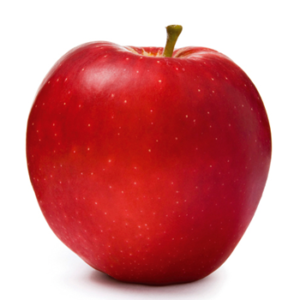

In [37]:
#comparison resize
normalimage = Image.open(files_train[20])
normalimage

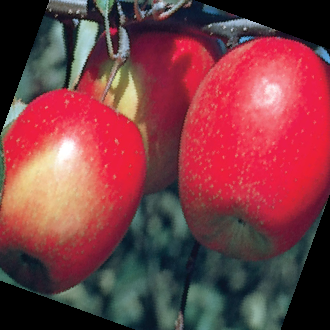

In [38]:
#data augmentation - rotate slightly because rotating at 90 degrees doesnt make much sense
#most of the photos are only slighted tilted
resized = Image.fromarray(x_train[22],'RGB')
resized


In [39]:
#plot all the train and test
def plot_summary_view(is_train):
    if is_train:
        x = x_train

    else:
        x = x_test


    plt.figure(figsize=(20,20))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.grid(False)
        plt.imshow(x[i])

    plt.show()

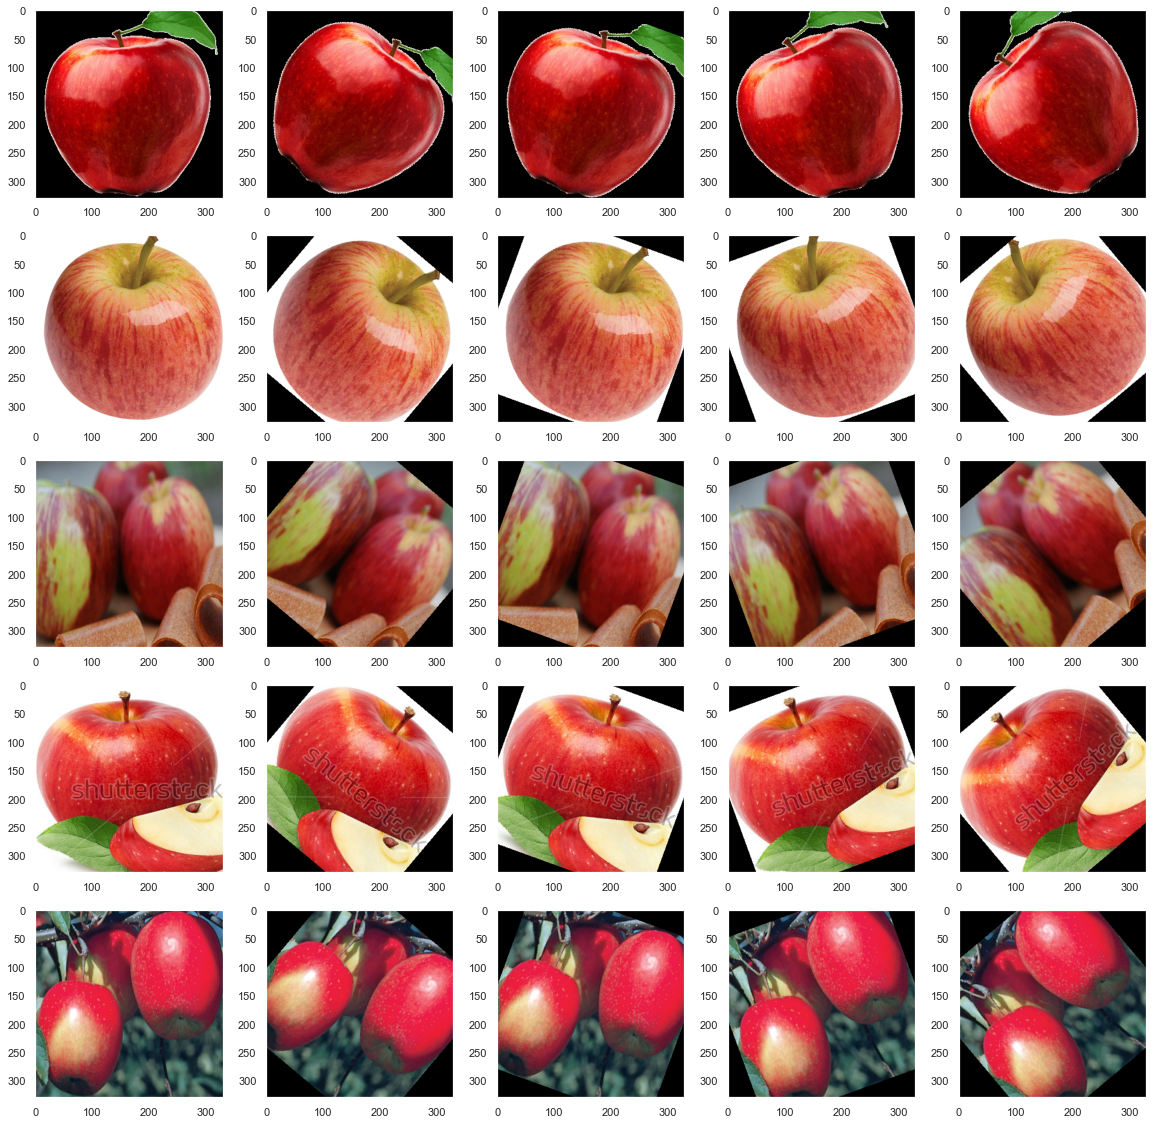

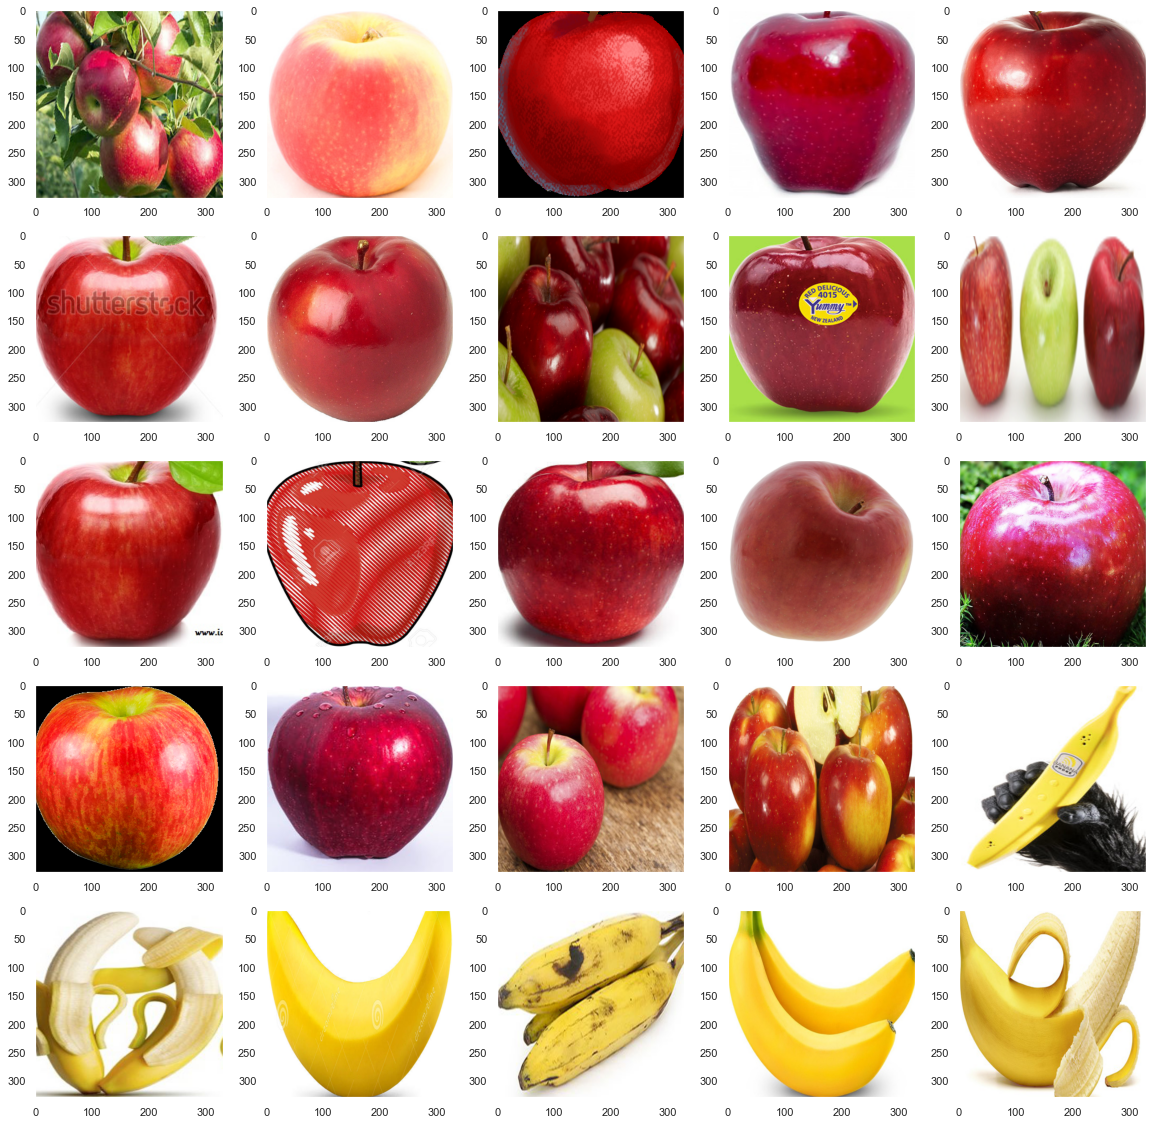

In [40]:
plot_summary_view(True)
plot_summary_view(False)

Construct structure for our CNN

In [45]:
keras.backend.clear_session()
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, padding='same',activation='relu',input_shape=(330,330,3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(500,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(units=4, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 330, 330, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 165, 165, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 165, 165, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 82, 82, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 82, 82, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 41, 41, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 41, 41, 128)       3

In [46]:
#specify hyper-parameters
model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [47]:
#train the model
hist = model.fit(x=x_train/255, y=y_train, epochs=10)

Epoch 1/5
38/38 [==============================] - 26s 678ms/step - loss: 1.0533 - accuracy: 0.6625
Epoch 2/5
38/38 [==============================] - 24s 637ms/step - loss: 0.2364 - accuracy: 0.9192
Epoch 3/5
38/38 [==============================] - 24s 643ms/step - loss: 0.1327 - accuracy: 0.9575
Epoch 4/5
38/38 [==============================] - 24s 631ms/step - loss: 0.0913 - accuracy: 0.9700
Epoch 5/5
38/38 [==============================] - 25s 656ms/step - loss: 0.0549 - accuracy: 0.9808


In [48]:
loss, accuracy = model.evaluate(x=x_test, y=y_test)

print('loss = ', loss)
print('accuracy = ', accuracy)

2/2 [==============================] - 0s 68ms/step - loss: 99.1233 - accuracy: 0.9167
loss =  99.123291015625
accuracy =  0.9166666865348816


# Appendix

#### We have also experimented with other smaller changes.

#### We have decided to only show the experiments with significant and impactful changes in detail, that shows breakthrough processes and findings in improving our model.

#### Please see below for the github link to the other experiments, and a short summary of the changes, loss and accuracy values of the other experiments.

## Experiments without data augmentation
- Batch Size = 25, Kernal size(3,3) and (5,5) epoch 100 : 485 loss, 60% accuracy
- Batch Size = 20, Kernal size (3,3) and (5,5), epoch 100 : 378 loss, 70% accuracy


## Experiments with data augmentation
- Rotation with nearest fill: loss 144, 88% accuracy
- Random data augmentation using image generator : 477 loss, 73% accuracy